In [1]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
print(os.getcwd())

import dLux as dl
import matplotlib.pyplot as plt
import alphacen as ac
import utils
from jax import vmap
import jax.numpy as np

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd


Creating AlphaCenPSF object and setting the relevant parameters

In [2]:
obj = ac.AlphaCenPSF(mask_dir='data/test_mask.npy', n_wavels=10)
obj.pa = 90  # position angle in degrees
obj.sep = 10  # binary separation in arcseconds
obj.flux = 6.152e7 / 10 / 2  # AVERAGE flux of the two stars per frame
obj.contrast = 3.372873  # flux contrast from V band magnitudes

AttributeError: module 'dLux.optics' has no attribute 'AddOPD'

Loading in the mask and creating/plotting the PSF

In [ ]:
optics, source = obj.GetInstrument()
idealPSF = optics.model(source)
PSF = ac.add_noise_to_psf(idealPSF)
utils.PlotSqrtPSF(PSF, title=r'$\alpha$ $Cen$ Simulated PSF')

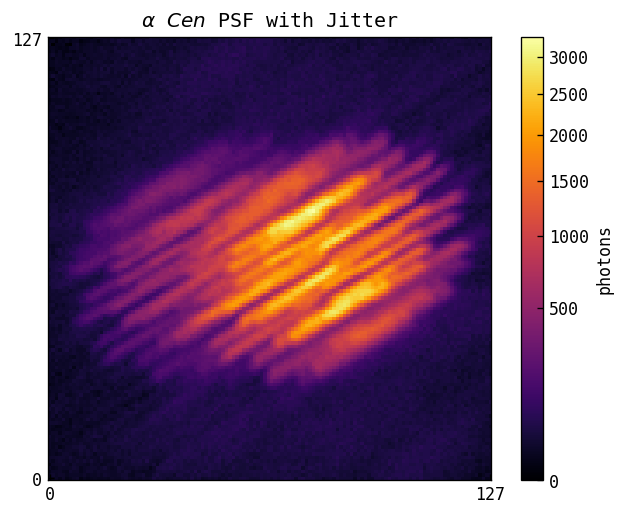

In [11]:
jitfunc = ac.get_jitter_func(optics, source)
jitPSF = jitfunc(rad=30, angle=30, npsf=15)
noisePSF = ac.add_noise_to_psf(jitPSF)
utils.PlotSqrtPSF(noisePSF, title=r'$\alpha$ $Cen$ PSF with Jitter')

In [ ]:
a